In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten

import tensorflow_addons as tfa
import cv2
import os 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import accuracy_score
import random 
import time

AUTOTUNE = tf.data.AUTOTUNE


c:\Users\krsty\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
N_BEF_RES = 256
N_RES = 256 
# N_CLASSES = 143 
N_BATCH = 32 

In [3]:
# PATH = 'C:/Users/user/Desktop/Child Skin Disease'
PATH = 'D:/Dropbox/2. WORK/SNUH/Child Skin Disease'
# os.listdir('C:/Users/user/Desktop/Child Skin Disease')

In [4]:
dataset = os.path.join(PATH, 'Total_Dataset')
dataset

'D:/Dropbox/2. WORK/SNUH/Child Skin Disease\\Total_Dataset'

In [5]:
# Train & test set
limit_num = 100
base_num = 100
train_dict = {}
test_dict = {} 

for i in range(6):
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    
    for f in files: 
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        if len(imgs) > limit_num: 
            
            if f in train_dict:
                train_dict[f] = train_dict[f] + len(imgs)
            else:
                train_dict[f] = len(imgs)
            
for i in range(7, 10): 
    files = [val for val in list(train_dict.keys())]
    
    for f in files:
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        if f in test_dict:
            test_dict[f] = test_dict[f] + len(imgs) 
        else:
            test_dict[f] = len(imgs) 
        
train_dict, test_dict

({'Acne': 1561,
  'Acne scar integrated': 380,
  'Alopecia areata': 2123,
  'Cafe-au-lait spot': 678,
  'Corn, Callus': 1376,
  'Cyst integrated': 1369,
  'Dermal Melanocytic Hamartoma': 262,
  'Epidermal nevus': 322,
  'Erythema dyschromicum perstans': 210,
  'Erythema multiforme': 686,
  'Erythema nodosum': 186,
  'Granuloma annulare': 143,
  'Hemangioma integrated': 437,
  'Ichthyosis': 117,
  'Impetigo': 401,
  'Ingrowing nail': 268,
  'Juvenile xanthogranuloma': 353,
  'Keloid scar': 947,
  'Lichen striatus': 672,
  'Localized scleroderma': 138,
  'Mastocytoma': 486,
  'Melanocytic nevus': 1482,
  'Melanonychia': 566,
  'Molluscum contagiosum': 825,
  'Mongolian spot': 465,
  'Nevus depigmentosus': 538,
  'Nevus of Ota': 351,
  'Nevus sebaceus': 587,
  'Normal': 2197,
  'Nummular eczema': 611,
  'Onychodystrophy': 793,
  'Onycholysis': 153,
  'Perioral dermatitis': 653,
  'Pityriasis alba': 655,
  'Pityriasis lichenoides': 480,
  'Pityriasis versicolor': 380,
  'Port-Wine stain': 

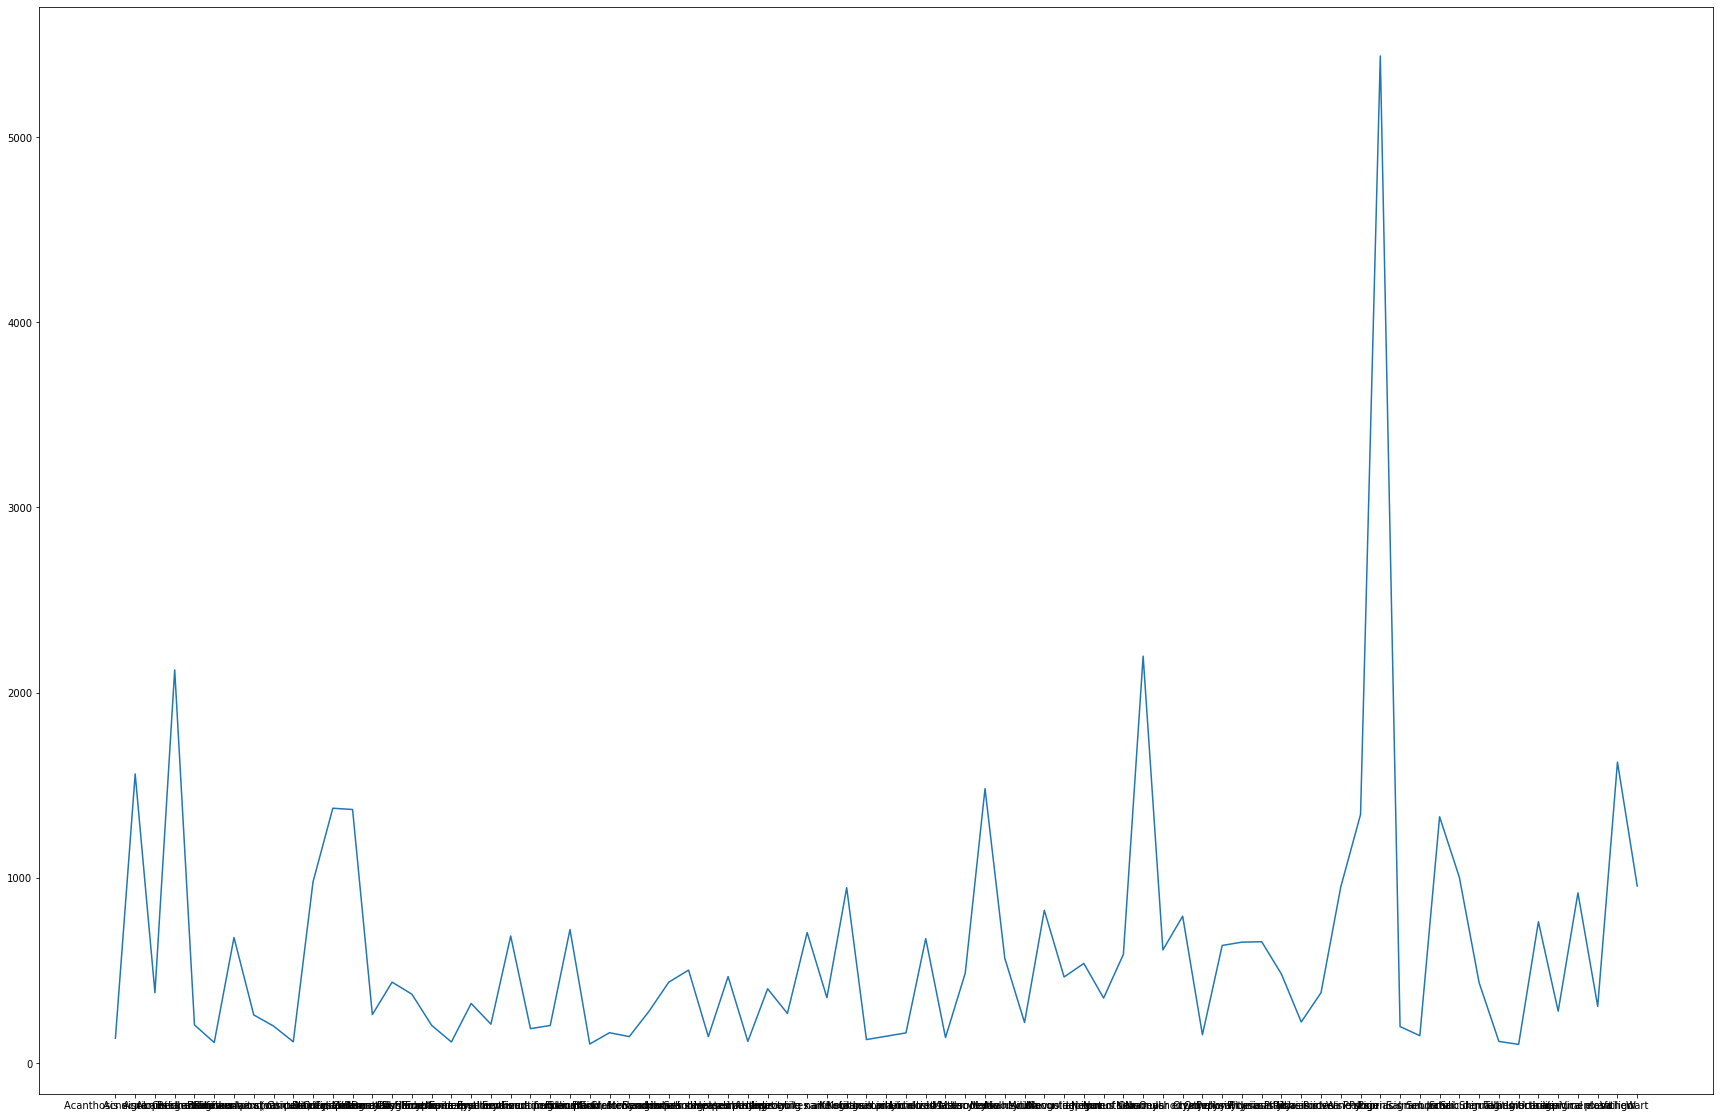

In [6]:
lists = sorted(train_dict.items())
lists

x, y = zip(*lists) 
plt.figure(figsize=(30, 20))
plt.plot(x, y)
plt.show()

In [7]:
N_CLASSES = len(train_dict)

In [8]:
train_images = [] 
test_images = []

for i in range(6):
    for key in train_dict.keys():
        img = glob(dataset + f'/H{str(i)}/{key}/*.jpg')
        train_images.extend(img) 
        
for i in range(7, 10):
    for key in train_dict.keys():
        img = glob(dataset + f'/H{str(i)}/{key}/*.jpg')
        test_images.extend(img) 
        
        
random.shuffle(train_images)
random.shuffle(test_images)
        
len(train_images), len(test_images)
        

(52516, 37369)

In [9]:
label_to_index = {}
for idx, key in zip(range(len(train_dict)), train_dict.keys()):
    label_to_index[key] = idx
    
label_to_index

{'Acne': 0,
 'Acne scar integrated': 1,
 'Alopecia areata': 2,
 'Cafe-au-lait spot': 3,
 'Corn, Callus': 4,
 'Cyst integrated': 5,
 'Dermal Melanocytic Hamartoma': 6,
 'Epidermal nevus': 7,
 'Erythema dyschromicum perstans': 8,
 'Erythema multiforme': 9,
 'Erythema nodosum': 10,
 'Granuloma annulare': 11,
 'Hemangioma integrated': 12,
 'Ichthyosis': 13,
 'Impetigo': 14,
 'Ingrowing nail': 15,
 'Juvenile xanthogranuloma': 16,
 'Keloid scar': 17,
 'Lichen striatus': 18,
 'Localized scleroderma': 19,
 'Mastocytoma': 20,
 'Melanocytic nevus': 21,
 'Melanonychia': 22,
 'Molluscum contagiosum': 23,
 'Mongolian spot': 24,
 'Nevus depigmentosus': 25,
 'Nevus of Ota': 26,
 'Nevus sebaceus': 27,
 'Normal': 28,
 'Nummular eczema': 29,
 'Onychodystrophy': 30,
 'Onycholysis': 31,
 'Perioral dermatitis': 32,
 'Pityriasis alba': 33,
 'Pityriasis lichenoides': 34,
 'Pityriasis versicolor': 35,
 'Port-Wine stain': 36,
 'Prurigo': 37,
 'Psoriasis': 38,
 'Scar': 39,
 'Seborrheic dermatitis': 40,
 'Subung

In [15]:
def train_skin_data(files):
    
    for file in files:
    
        f = file.decode('utf-8')
        
        img = cv2.imread(f, cv2.COLOR_BGR2YCR_CB)
        img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

        idx = f.split('\\')[1].split('/')[2]
        lbl = tf.keras.utils.to_categorical(label_to_index[idx], len(train_dict))

        yield (img, lbl)    
        
        # if lower than base num, should apply data augmentation
        if base_num <= int(train_dict[idx]):

            # Btight 
            random_bright_tensor = tf.image.random_brightness(img, max_delta=128)
            random_bright_tensor = tf.clip_by_value(random_bright_tensor, 0, 255)
            random_bright_image = tf.keras.preprocessing.image.array_to_img(random_bright_tensor)
            yield (random_bright_tensor, lbl) 
    
            # rotation
            rotated_img = tf.image.rot90(img)        
            yield (rotated_img, lbl) 
            
            # curmix 
            cutmixed_img, cutmixed_lbl = cutmix(img, lbl)
            yield (cutmixed_img, cutmixed_lbl)

        

In [16]:
def test_skin_data(files):
    
    for file in files:
    
        f = file.decode('utf-8')
        
        img = cv2.imread(f, cv2.COLOR_BGR2YCR_CB)
        img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        
        lbl = tf.keras.utils.to_categorical(label_to_index[f.split('\\')[1].split('/')[2]], len(train_dict))

        yield (img, lbl)    

In [17]:
def cutmix(images, labels):
    # imgs = []; labs = []
    # for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32)
    idx = tf.random.uniform((), 0, len(train_images), tf.int32)
    
    # random_img = 0 
    # random_lbl = 0 
    
    random_img = cv2.imread(train_images[idx], cv2.COLOR_BGR2YCR_CB)
    random_img = cv2.resize(random_img, (N_BEF_RES, N_BEF_RES))
    random_img = cv2.normalize(random_img, None, 0, 255, cv2.NORM_MINMAX)
    random_lbl = tf.keras.utils.to_categorical(label_to_index[train_images[idx].split('\\')[1].split('/')[2]], len(train_dict))

    W = N_RES
    H = N_RES
    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam)
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
    cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H)

    mid_left = images[ymin:ymax, :xmin, :]
    # mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
    mid_mid = random_img[ymin:ymax, xmin:xmax, :]
    mid_right = images[ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
    top = images[:ymin, :, :]
    bottom = images[ymax:, :, :]
    new_img = tf.concat([top, middle, bottom], axis=0)
    # imgs.append(new_img)

    cut_w_mod = xmax - xmin
    cut_h_mod = ymax - ymin
    alpha = tf.cast((cut_w_mod*cut_h_mod)/(W*H), tf.float32)
    # label1 = labels[i]
    label1 = labels
    # label2 = labels[idx]
    label2 = random_lbl
    new_label = ((1-alpha)*label1 + alpha*label2)
    # labs.append(new_label)
        
    # new_imgs = tf.reshape(tf.stack(imgs), [-1, N_RES, N_RES, 3])
    # new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASSES])

    return new_img, new_label

In [18]:
def get_dropout(input_tensor, p=0.3, mc=False):
    if mc: 
        layer = Dropout(p, name='top_dropout')
        return layer(input_tensor, training=True)
    else:
        return Dropout(p, name='top_dropout')(input_tensor, training=False)

In [19]:
import math
def create_class_weight(labels_dict, mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for idx, key in zip(range(N_CLASSES), keys):
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[idx] = score
    
    return class_weight

class_weights = create_class_weight(train_dict)
# ttest
class_weights

{0: 1.522296074427668,
 1: 2.9352067422226686,
 2: 1.214792533239844,
 3: 2.3562307070027044,
 4: 1.6484419764498113,
 5: 1.653542169654651,
 6: 3.307033491182003,
 7: 3.1008264493986917,
 8: 3.5282704642256313,
 9: 2.344500367217215,
 10: 3.649631321229899,
 11: 3.912533364683193,
 12: 2.79544479984751,
 13: 4.113204060145344,
 14: 2.881416567636531,
 15: 3.2843910144322437,
 16: 3.008909938009803,
 17: 2.022078901757022,
 18: 2.3651196544199506,
 19: 3.9481243097858956,
 20: 2.689169371042606,
 21: 1.574230189087068,
 22: 2.536783916739917,
 23: 2.159994608608419,
 24: 2.733340589355744,
 25: 2.5875194347813157,
 26: 3.0145917714772343,
 27: 2.5003531751150034,
 28: 1.18052992255849,
 29: 2.4602810357715046,
 30: 2.199554773308252,
 31: 3.8449400735506645,
 32: 2.393800865666669,
 33: 2.390742759307848,
 34: 2.7015918910411636,
 35: 2.9352067422226686,
 36: 2.01786393239771,
 37: 1.673461677411473,
 38: 0.2743952777971794,
 39: 1.6824437737273006,
 40: 1.9646272069811646,
 41: 4.1132

In [20]:
def run_expriment(model_name, train_dataset, val_dataset, batch_size=32, mc=False, epochs=100, n_splits=5): 
    
    if model_name == 'efficient':
        # base_model = keras.applications.EfficientNetB0(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model = keras.applications.EfficientNetB7(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model.trainable = True
        
        inputs = keras.Input(shape=(N_RES, N_RES, 3))
        x = base_model(inputs)
        x = keras.layers.GlobalAveragePooling2D()(x) 
        x = get_dropout(x, mc)
        x = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        
    # VGG16 
    else:
        base_model = keras.applications.VGG16(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model.trainable = True
        
        inputs = keras.Input(shape=(N_RES, N_RES, 3))
        x = base_model(inputs)
        x = keras.layers.Flatten(name = "avg_pool")(x) 
        x = keras.layers.Dense(512, activation='relu')(x)
        x = get_dropout(x, mc)
        x = keras.layers.Dense(256, activation='relu')(x)
        x = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        

    sv = [tf.keras.callbacks.ModelCheckpoint(os.path.join(f'models/{model_name}_mc_{str(mc)}_{time.strftime("%Y%m%d-%H%M%S")}.h5'), 
                                            monitor='val_loss', 
                                            verbose=0, 
                                            save_best_only=True,
                                            save_weights_only=True, 
                                            mode='min', 
                                            save_freq='epoch'), 
          tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                           patience = 4, 
                                           min_delta = 0.01)]

    
    LR = 0.0001
    steps_per_epoch = len(train_images) // batch_size
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LR, steps_per_epoch*30, 0.1, True)
    
    # model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
    #                 optimizer = tf.keras.optimizers.Adam(lr_schedule), 
    #                 metrics=['accuracy'])
    # model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
    #                 optimizer = tf.keras.optimizers.SGD(), 
    #                 metrics=['accuracy'])
    model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), 
                    optimizer = tf.keras.optimizers.Adam(lr_schedule), 
                    metrics=['accuracy'])
    
    hist = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = epochs,
                    class_weight=class_weights, 
                    verbose = 1,
                    shuffle = True,
                    callbacks = [sv])
    
    # histories.append(hist)
    
    return model, hist
    

In [21]:
# train_dataset = create_dataset(train_images)
# test_dataset = create_dataset(test_images)

train_dataset = tf.data.Dataset.from_generator(train_skin_data, 
                                               output_types=(tf.float64, tf.float32), 
                                               output_shapes=(tf.TensorShape([N_BEF_RES, N_BEF_RES, 3]), tf.TensorShape([N_CLASSES])),
                                               args=[train_images])

test_dataset = tf.data.Dataset.from_generator(test_skin_data, 
                                              output_types=(tf.float64, tf.float32), 
                                              output_shapes=(tf.TensorShape([N_BEF_RES, N_BEF_RES, 3]), tf.TensorShape([N_CLASSES])),
                                              args=[test_images])


In [22]:
def make_pairs(x, y):
    print(len(x))
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

In [23]:
train_dataset = train_dataset.map(make_pairs)

OperatorNotAllowedInGraphError: in user code:

    File "C:\Users\krsty\AppData\Local\Temp/ipykernel_24984/3894956916.py", line 2, in make_pairs  *
        num_classes = max(y) + 1

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.


In [30]:
split_size = int(len(train_images) * 0.2)
split_train_dataset = train_dataset.skip(split_size)
split_val_dataset = train_dataset.take(split_size)

# new_split_train_dataset = split_train_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)
# val_dataset = val_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)

# batch_list = [1, 8, 16, 32, 64]
batch_list = [16, 32, 64]

for batch in batch_list:
    
    # new_split_train_dataset = split_train_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(batch, drop_remainder=True).prefetch(AUTOTUNE)
    # new_split_vbal_dataset = split_val_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(batch, drop_remainder=True).prefetch(AUTOTUNE)
    new_split_train_dataset = split_train_dataset.shuffle(150).batch(batch, drop_remainder=True).prefetch(AUTOTUNE)
    new_split_val_dataset = split_val_dataset.shuffle(150).batch(batch, drop_remainder=True).prefetch(AUTOTUNE)

    with tf.device('/device:GPU:0'):
        model, hist = run_expriment('efficient', new_split_train_dataset, new_split_val_dataset, batch_size=batch, mc=True, epochs=100)

Epoch 1/100
7810/7810 [==============================] - 4864s 612ms/step - loss: 1.0480 - accuracy: 0.4369 - val_loss: 0.3957 - val_accuracy: 0.5005
Epoch 2/100
7810/7810 [==============================] - 5027s 635ms/step - loss: 0.6587 - accuracy: 0.5699 - val_loss: 0.3541 - val_accuracy: 0.5696
Epoch 3/100
7810/7810 [==============================] - 4789s 605ms/step - loss: 0.5066 - accuracy: 0.6380 - val_loss: 0.3371 - val_accuracy: 0.5834
Epoch 4/100
7810/7810 [==============================] - 4844s 612ms/step - loss: 0.4277 - accuracy: 0.6761 - val_loss: 0.3425 - val_accuracy: 0.5970
Epoch 5/100
7810/7810 [==============================] - 4767s 602ms/step - loss: 0.3819 - accuracy: 0.6998 - val_loss: 0.3266 - val_accuracy: 0.6080
Epoch 6/100
7810/7810 [==============================] - 4734s 598ms/step - loss: 0.3557 - accuracy: 0.7169 - val_loss: 0.3347 - val_accuracy: 0.6140
Epoch 7/100
7810/7810 [==============================] - 4770s 602ms/step - loss: 0.3399 - accuracy:

KeyboardInterrupt: 

In [22]:
split_size = int(len(train_images) * 0.2)
split_train_dataset = train_dataset.skip(split_size)
splot_val_dataset = train_dataset.take(split_size)

In [23]:
# new_split_train_dataset = split_train_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
# val_dataset = val_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
new_split_train_dataset = split_train_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)
val_dataset = val_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)

In [24]:
with tf.device('/device:GPU:0'):
    model, hist = run_expriment('efficient', new_split_train_dataset, val_dataset, mc=True, epochs=100)

Epoch 1/100
1312/1312 [==============================] - 426s 263ms/step - loss: 6.9445 - accuracy: 0.3029 - val_loss: 2.1484 - val_accuracy: 0.4327
Epoch 2/100
1312/1312 [==============================] - 412s 266ms/step - loss: 4.4906 - accuracy: 0.4926 - val_loss: 1.7297 - val_accuracy: 0.5252
Epoch 3/100
1312/1312 [==============================] - 414s 267ms/step - loss: 3.5900 - accuracy: 0.5775 - val_loss: 1.5232 - val_accuracy: 0.5761
Epoch 4/100
1312/1312 [==============================] - 415s 268ms/step - loss: 3.0350 - accuracy: 0.6337 - val_loss: 1.4046 - val_accuracy: 0.6078
Epoch 5/100
1312/1312 [==============================] - 416s 268ms/step - loss: 2.6196 - accuracy: 0.6778 - val_loss: 1.3935 - val_accuracy: 0.6206
Epoch 6/100
1312/1312 [==============================] - 422s 272ms/step - loss: 2.2622 - accuracy: 0.7155 - val_loss: 1.3055 - val_accuracy: 0.6388
Epoch 7/100
1312/1312 [==============================] - 418s 269ms/step - loss: 1.9705 - accuracy: 0.7488

In [70]:
# test_dataset[0][0]test_dataset
# y_pred = model.predict(test_dataset) 
test_dataset = tf.data.Dataset.from_generator(get_skin_data, 
                                            output_types=(tf.float64, tf.float32), 
                                            output_shapes=(tf.TensorShape([224, 224, 3]), tf.TensorShape([N_CLASSES])),
                                            args=[test_images]).batch(64)

# test_dataset
y_pred = model.predict(test_dataset)

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.
Traceback (most recent call last):

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1047, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.
Traceback (most recent call last):

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1047, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_1784584]

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.
Traceback (most recent call last):

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1047, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.
Traceback (most recent call last):

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1047, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_1784584]

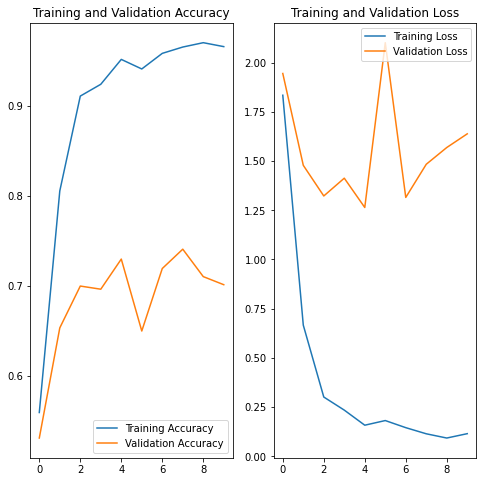

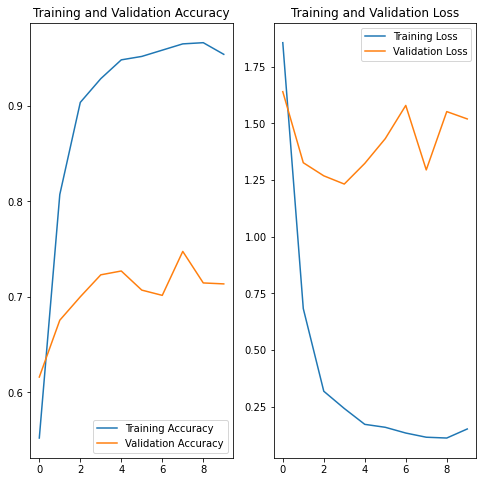

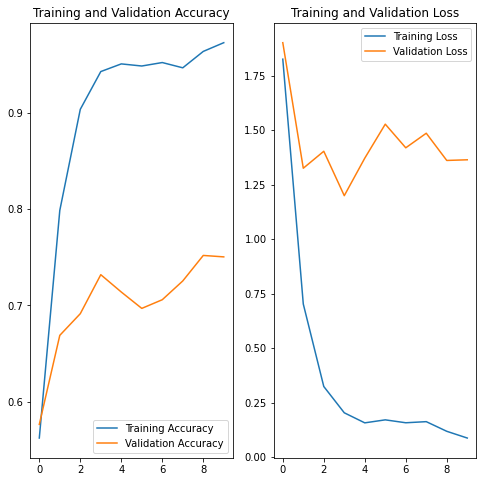

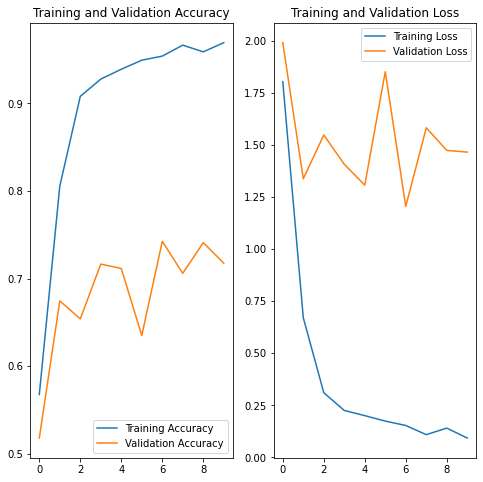

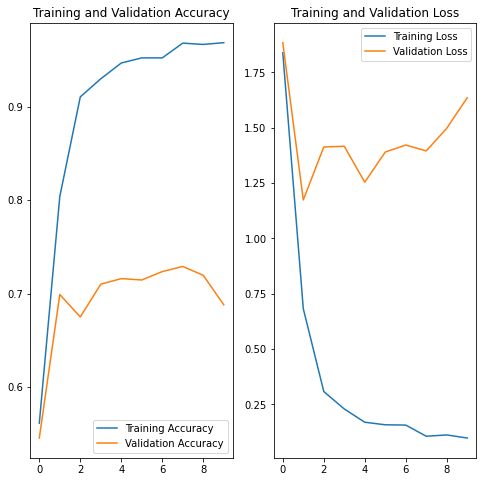

In [30]:
# hist
# for hist in histories:
plt.figure(1, figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()